In [1]:
# -*- coding: utf-8 -*-

import os
import re
import pickle
import numpy as np
from copy import deepcopy
from glob import glob
from tqdm import tqdm
from collections import OrderedDict
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import *

np.random.seed(7)
torch.manual_seed(7)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [2]:
!which python

/home/jk6373/pyenv/ssml/bin/python


In [3]:
!hostname

gpu-32


In [4]:
DATA_ROOT = '/beegfs/bva212/openmic-2018'
OPENMIC = np.load(os.path.join(DATA_ROOT, 'openmic-2018.npz'), allow_pickle=True)
X, Y_true, Y_mask, sample_key = OPENMIC['X'], OPENMIC['Y_true'], OPENMIC['Y_mask'], OPENMIC['sample_key']

In [22]:
len_data = Y_mask.shape[0]
idx_train = np.random.choice(len_data, int(len_data*0.7), replace=False)
remain_set = set(np.arange(len_data))-set(idx_train)
idx_test = np.random.choice(list(remain_set), int(len_data*0.1), replace=False)
idx_val = list(remain_set-set(idx_test))

In [23]:
Y_mask_train = Y_mask[idx_train]
Y_mask_val = Y_mask[idx_val]
Y_mask_test = Y_mask[idx_test]

label_train = Y_true[idx_train]
label_val = Y_true[idx_val]
label_test = Y_true[idx_test]

In [24]:
new_weights_train = weights_train.reshape(-1,1)*Y_mask_train
weight = np.concatenate([item['weight'] for item in batch],axis=0)
weights_val = np.sum(Y_mask_val, axis= 1)/20
new_weights_val = weights_val.reshape(-1,1)*Y_mask_val
weights_test = np.sum(Y_mask_test, axis= 1)/20
new_weights_test = weights_test.reshape(-1,1)*Y_mask_test

In [8]:
class CQTLoader(Dataset):

    def __init__(self, root_dir, files, mask, label):
        self.mask = mask
        self.device = device
        self.root_dir = root_dir
        self.files = files
        self.label = label

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        logscalogram = np.load(self.root_dir + self.files[idx]+'_cqt.npy')
        mask = self.mask[idx]
        label = self.label[idx]
        return {'logscalogram': logscalogram[np.newaxis, :], 'label': label[np.newaxis, :], 'mask': mask[np.newaxis,:]}

filenames = []
root_dir = '/beegfs/bva212/openmic-2018/cqt_full/'

BATCH_SIZE = 8

def my_collate(batch):
    data = np.concatenate([item['logscalogram'] for item in batch],axis=0)
    data = np.expand_dims(data, axis = 1)
    target = np.concatenate([item['label'] for item in batch],axis=0)
    weights_train = np.sum([item['mask'] for item in batch], axis= 1)
    return [torch.from_numpy(data).float(), torch.from_numpy(target).float(), torch.from_numpy(weight).float()]

Train_dataset = CQTLoader(root_dir, sample_key[idx_train], Y_mask[idx_train], Y_true[idx_train])
Train_loader = DataLoader(dataset = Train_dataset, 
                                              batch_size = BATCH_SIZE,
                                              shuffle = True,
                                          collate_fn = my_collate)

Val_dataset = CQTLoader(root_dir, sample_key[idx_val], Y_mask[idx_val], Y_true[idx_val])
Val_loader = DataLoader(dataset = Val_dataset, 
                                              batch_size = BATCH_SIZE,
                                              shuffle = True,
                                        collate_fn = my_collate)

Test_dataset = CQTLoader(root_dir, sample_key[idx_test], Y_mask[idx_test], Y_true[idx_test])
Test_loader = DataLoader(dataset = Test_dataset, 
                                              batch_size = BATCH_SIZE,
                                              shuffle = True,
                                        collate_fn = my_collate)

In [9]:
size_list=[]
for spectrogram, target, weight in Test_loader:
        size_list.append(spectrogram.shape)
for spectrogram, target, weight in Val_loader:
        size_list.append(spectrogram.shape)
for spectrogram, target, weight in Train_loader:
        size_list.append(spectrogram.shape)
set(size_list)

{torch.Size([8, 1, 84, 431])}

In [10]:
class AudioConvNet(nn.Module):

    def __init__(self, fc):
        '''
        Create the 5 Conv Layer Sound Net network architecture as per the paper - https://arxiv.org/pdf/1610.09001.pdf
        '''
        super(AudioConvNet, self).__init__()

        self.conv_layers = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels= 16, kernel_size = 5, stride = 2, padding = 5), 
                                nn.BatchNorm2d(num_features = 16), 
                                nn.ReLU(inplace = True),

                                nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, stride = 2, padding = 5),
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace = True),

                                nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, padding = 5),
                                nn.BatchNorm2d(64),
                                nn.ReLU(inplace = True),
                                nn.AvgPool2d(kernel_size = 3),

                                nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 4, padding = 4),
                                nn.BatchNorm2d(128),
                                nn.ReLU(inplace = True),

                                nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 4, padding = 4),
                                nn.BatchNorm2d(256),
                                nn.ReLU(inplace = True),
                                nn.AvgPool2d(kernel_size = 3),

                                nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 2, padding = 3),
                                nn.BatchNorm2d(512),
                                nn.ReLU(inplace = True),

                                nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, stride = 2, padding = 3),
                                nn.BatchNorm2d(1024),
                                nn.ReLU(inplace = True),
                                nn.AdaptiveAvgPool2d(output_size = 1)
                                )
        
        self.fc = fc
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='relu')


    def forward(self, input):
        conv_strips = []
        n_strips = input.shape[1]
        for strip in range(n_strips):
            conv_strip = input[:,strip]
            conv_strip = conv_strip.unsqueeze(1)
            conv_strips.append(self.conv_layers(conv_strip))

        concat_out=torch.cat(conv_strips,1)
        return self.fc(np.squeeze(concat_out))

# Function for testing the model
def test_model(loader, model):
    correct = 0
    total_loss = 0
    total = 0
    total_num = 0
    model.eval()
    with torch.no_grad():
        for spectrogram, target, weight in loader:
            spectrogram_batch, target_batch, weight_batch = spectrogram.to(device), target.to(device), weight.to(device)
            outputs = model(spectrogram_batch)
#             print(label_batch.shape)
            predicted = (torch.sigmoid(outputs.data)>0.5).float()
            loss = F.binary_cross_entropy_with_logits(outputs, target_batch,
                                                  weight = weight_batch,
                                                  reduction='sum')
            total_loss += loss.item()
            total += weight_batch.shape[0]

            correct += ((weight_batch != 0).float()*(predicted.eq(target_batch.view_as(predicted)).float())).sum().item()
            total_num += (weight_batch != 0).sum().item()
    return (100 * correct / total_num), (total_loss/total)

def train_model(train_loader, val_loader, model, optimizer, scheduler, num_epochs):
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []
    best_val_acc = 0
    model.eval()
    for epoch in range(num_epochs):
        for spectrogram, target, weight in train_loader:
            spectrogram_batch, target_batch, weight_batch = spectrogram.to(device), target.to(device), weight.to(device)
            optimizer.zero_grad()
            outputs = model(spectrogram_batch)
#             print(label_batch.shape)
            loss = F.binary_cross_entropy_with_logits(outputs, target_batch,
                                                  weight = weight_batch,
                                                  reduction='mean')
#             print(loss)
            loss.backward()
            optimizer.step()
        train_acc, train_loss = test_model(train_loader, model)
        val_acc, val_loss = test_model(val_loader, model)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state_dict = deepcopy(model.state_dict())
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)
        scheduler.step(val_acc)
#         print("Epoch:{}, Validation Accuracy:{:.2f}, Training Acc: {:.2f}, Val Loss: {:.5f}, Train Loss: {:.5f}".format(epoch+1, val_acc, train_acc, val_loss, train_loss))
    return train_acc_list, train_loss_list, val_acc_list, val_loss_list, best_model_state_dict
        
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
    
class SimpleMLP_Model(nn.Module):
    """
    SimpleMLP classification model
    """
    def __init__(self):
        
        super(SimpleMLP_Model, self).__init__()
        #self.linear1 = nn.Linear(49152,512)
        #self.linear1 = nn.Linear(1024,512)
        #self.linear2 = nn.Linear(512,256)
        #self.linear3 = nn.Linear(256,10)
        self.linear = nn.Linear(1024,20)
    
    
    def forward(self,x):
        #x = x.view(x.size(0), -1)
        #x = nn.Linear(x.size(0),1024)(x)
        #x = F.relu(self.linear1(x))
        #x = F.relu(self.linear2(x))
        #x = self.linear3(x)  
        x = self.linear(x)
        return x

In [11]:
r1 = re.compile('conv_layers')

def run_model(model_state_dict, lr, num_epochs, model_suffix):
    
    # Prepare/load model
    model = AudioConvNet(fc=Identity())
    
    if model_state_dict is not None: 
        for key in list(model_state_dict.keys()):
            cs = r1.search(key)
            if cs is None:
                del model_state_dict[key]
            else:
                model_state_dict[key[cs.start():]] = model_state_dict[key]
                del model_state_dict[key]
    #         print(model, model.state_dict().keys())
        model.load_state_dict(model_state_dict)
        
    for param in model.parameters():
            param.requires_grad = False
            
    model.fc = SimpleMLP_Model()
#     print(model, model.state_dict())
    model.to(device)

    # Train
    torch.optim.Adam([param for param in model.parameters() if param.requires_grad == True], lr=lr, weight_decay = 0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True, \
                                                           threshold=0.03, threshold_mode='abs', cooldown=0, min_lr=0, eps=1e-08)
    train_acc_list, train_loss_list, val_acc_list, val_loss_list, best_model_state_dict = train_model(Train_loader, Val_loader, \
                                                                                                      model, optimizer, scheduler, num_epochs)
    
    file_path = '/home/jk6373/self_supervised_machine_listening/model/'
    file_name = 'downstream_frozen_' + model_suffix
    torch.save({
        'train_acc_list': train_acc_list,
        'train_loss_list': train_loss_list,
        'val_acc_list': val_acc_list,
        'val_loss_list': val_loss_list,
        'model_state_dict': best_model_state_dict
        }, file_path+file_name)

    #Plot
    fig = plt.figure()
    fig.set_size_inches(12,8)
    plt.plot(train_acc_list, label='Train')
    plt.plot(val_acc_list, label='Val')
    plt.xlabel('Epoch#')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()
    
    fig = plt.figure()
    fig.set_size_inches(12,8)
    plt.plot(train_loss_list, label='Train')
    plt.plot(val_loss_list, label='Val')
    plt.xlabel('Epoch#')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.show()

Epoch:1, Validation Accuracy:45.17, Training Acc: 44.90, Val Loss: 0.69343, Train Loss: 0.67570
Epoch:2, Validation Accuracy:44.93, Training Acc: 44.53, Val Loss: 0.81801, Train Loss: 0.82182
Epoch:3, Validation Accuracy:48.52, Training Acc: 49.03, Val Loss: 0.78165, Train Loss: 0.78234
Epoch:4, Validation Accuracy:48.99, Training Acc: 49.45, Val Loss: 0.89023, Train Loss: 0.86101
Epoch:5, Validation Accuracy:48.12, Training Acc: 49.39, Val Loss: 0.72989, Train Loss: 0.65886
Epoch:6, Validation Accuracy:43.14, Training Acc: 43.64, Val Loss: 0.83489, Train Loss: 0.76970
Epoch     6: reducing learning rate of group 0 to 1.0000e-03.
Epoch:7, Validation Accuracy:47.70, Training Acc: 48.51, Val Loss: 0.63244, Train Loss: 0.60811
Epoch:8, Validation Accuracy:52.47, Training Acc: 53.63, Val Loss: 0.27242, Train Loss: 0.23780
Epoch:9, Validation Accuracy:51.68, Training Acc: 52.65, Val Loss: 0.25173, Train Loss: 0.21650
Epoch:10, Validation Accuracy:52.42, Training Acc: 53.48, Val Loss: 0.2426

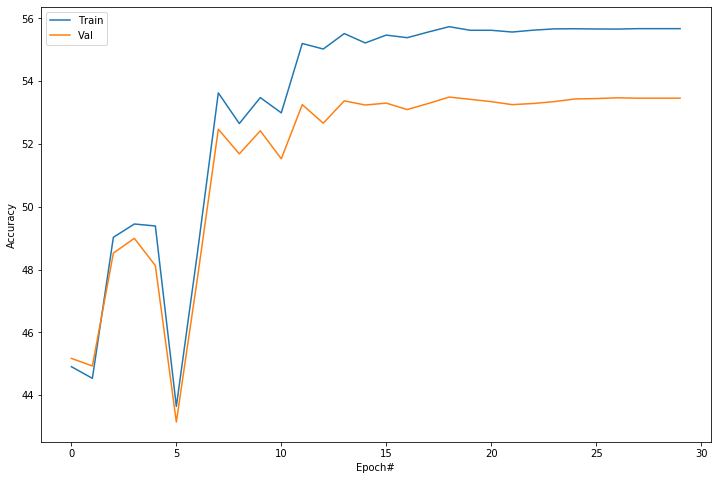

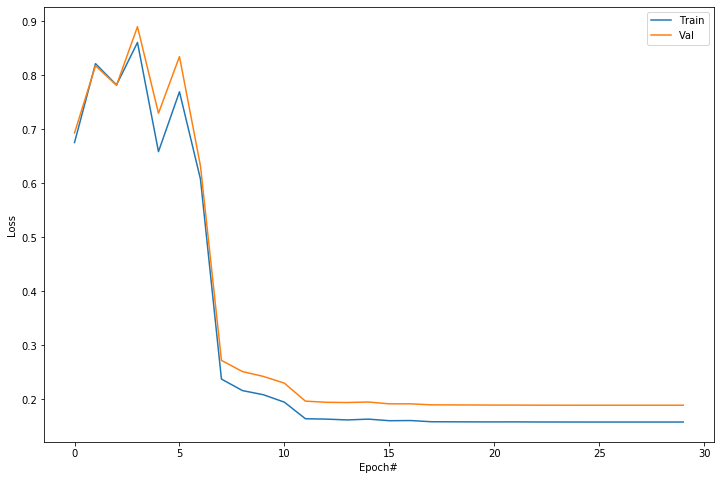

In [12]:
# Random initialization
run_model(model_state_dict=None, lr=0.01, num_epochs=30, model_suffix='random_init')

Epoch:1, Validation Accuracy:44.58, Training Acc: 44.50, Val Loss: 0.31640, Train Loss: 0.31693
Epoch:2, Validation Accuracy:45.05, Training Acc: 46.05, Val Loss: 0.32192, Train Loss: 0.30804
Epoch:3, Validation Accuracy:46.46, Training Acc: 46.54, Val Loss: 0.37517, Train Loss: 0.38619
Epoch:4, Validation Accuracy:40.66, Training Acc: 39.89, Val Loss: 0.31989, Train Loss: 0.31488
Epoch:5, Validation Accuracy:43.91, Training Acc: 44.67, Val Loss: 0.32592, Train Loss: 0.30991
Epoch     5: reducing learning rate of group 0 to 1.0000e-03.
Epoch:6, Validation Accuracy:43.64, Training Acc: 43.91, Val Loss: 0.41938, Train Loss: 0.40718
Epoch:7, Validation Accuracy:52.74, Training Acc: 53.23, Val Loss: 0.16280, Train Loss: 0.15459
Epoch:8, Validation Accuracy:52.33, Training Acc: 52.92, Val Loss: 0.16306, Train Loss: 0.15514
Epoch:9, Validation Accuracy:53.09, Training Acc: 53.77, Val Loss: 0.15752, Train Loss: 0.14957
Epoch:10, Validation Accuracy:52.49, Training Acc: 53.40, Val Loss: 0.1652

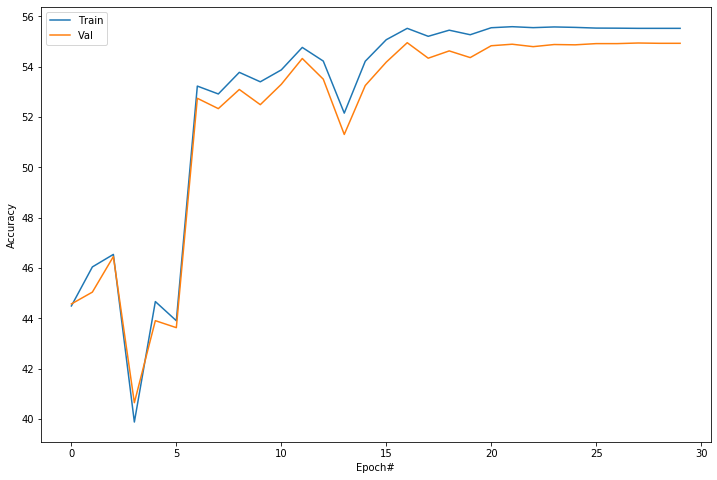

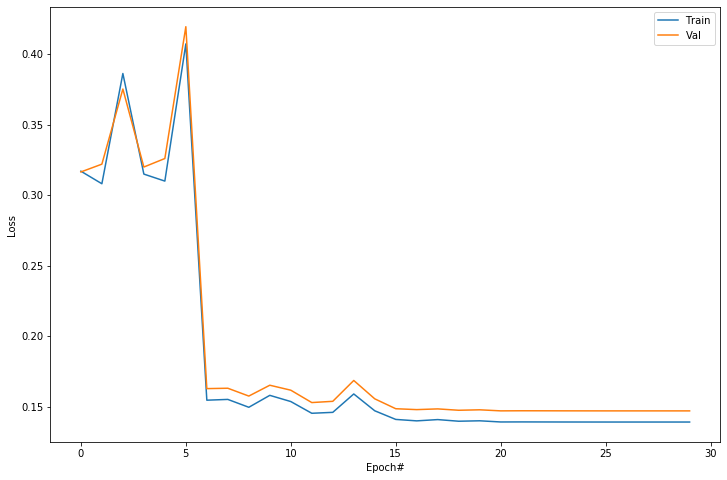

In [13]:
# Jigsaw initialization - 10/3
ref_msd = torch.load('/beegfs/sc6957/capstone/models/20191105/snet2_jigsaw_large_checkpoint_model_5.pth')['bestModelStateDict']

run_model(model_state_dict=ref_msd, lr=0.01, num_epochs=30, model_suffix='jigsaw_10_3_linear_chkpnt_5')

Epoch:1, Validation Accuracy:46.06, Training Acc: 45.50, Val Loss: 0.24553, Train Loss: 0.25243
Epoch:2, Validation Accuracy:48.98, Training Acc: 48.78, Val Loss: 0.33445, Train Loss: 0.33584
Epoch:3, Validation Accuracy:47.10, Training Acc: 47.16, Val Loss: 0.31500, Train Loss: 0.31049
Epoch:4, Validation Accuracy:40.79, Training Acc: 39.92, Val Loss: 0.48973, Train Loss: 0.48954
Epoch     4: reducing learning rate of group 0 to 1.0000e-03.
Epoch:5, Validation Accuracy:44.38, Training Acc: 44.13, Val Loss: 0.31337, Train Loss: 0.30947
Epoch:6, Validation Accuracy:50.14, Training Acc: 49.88, Val Loss: 0.17243, Train Loss: 0.16866
Epoch:7, Validation Accuracy:50.03, Training Acc: 49.71, Val Loss: 0.17149, Train Loss: 0.16781
Epoch:8, Validation Accuracy:49.39, Training Acc: 49.19, Val Loss: 0.17809, Train Loss: 0.17321
Epoch     8: reducing learning rate of group 0 to 1.0000e-04.
Epoch:9, Validation Accuracy:49.58, Training Acc: 49.47, Val Loss: 0.17068, Train Loss: 0.16665
Epoch:10, Va

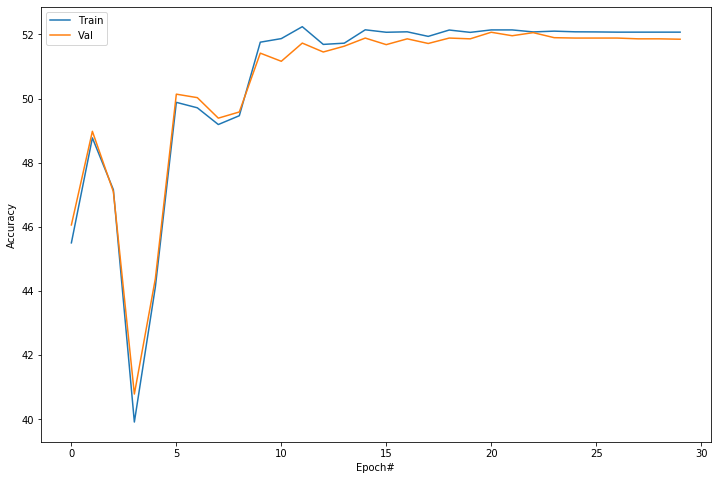

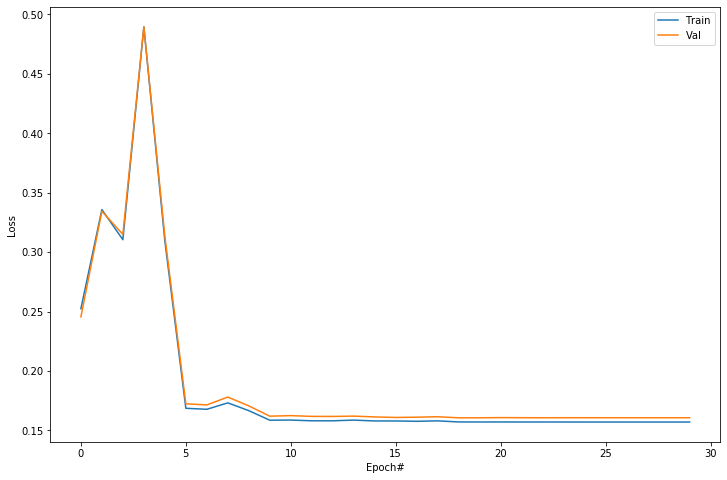

In [14]:
# Jigsaw initialization - 10/3
model_state_dict = torch.load('/beegfs/sc6957/capstone/models/20191106/snet2_jigsaw_large_best_model.pth')['modelStateDict']

run_model(model_state_dict=model_state_dict, lr=0.01, num_epochs=30, model_suffix='jigsaw_10_3_linear_best')

Epoch:1, Validation Accuracy:48.02, Training Acc: 48.53, Val Loss: 0.29601, Train Loss: 0.28591
Epoch:2, Validation Accuracy:43.39, Training Acc: 43.51, Val Loss: 0.36644, Train Loss: 0.35556
Epoch:3, Validation Accuracy:50.69, Training Acc: 51.25, Val Loss: 0.35243, Train Loss: 0.32969
Epoch:4, Validation Accuracy:48.87, Training Acc: 47.76, Val Loss: 0.30237, Train Loss: 0.30280
Epoch:5, Validation Accuracy:46.44, Training Acc: 46.49, Val Loss: 0.26737, Train Loss: 0.26418
Epoch     5: reducing learning rate of group 0 to 1.0000e-03.
Epoch:6, Validation Accuracy:47.10, Training Acc: 46.43, Val Loss: 0.25982, Train Loss: 0.25937
Epoch:7, Validation Accuracy:52.88, Training Acc: 53.00, Val Loss: 0.16130, Train Loss: 0.15655
Epoch:8, Validation Accuracy:52.33, Training Acc: 52.58, Val Loss: 0.16453, Train Loss: 0.15747
Epoch:9, Validation Accuracy:51.49, Training Acc: 51.73, Val Loss: 0.16919, Train Loss: 0.16190
Epoch:10, Validation Accuracy:53.37, Training Acc: 53.74, Val Loss: 0.1584

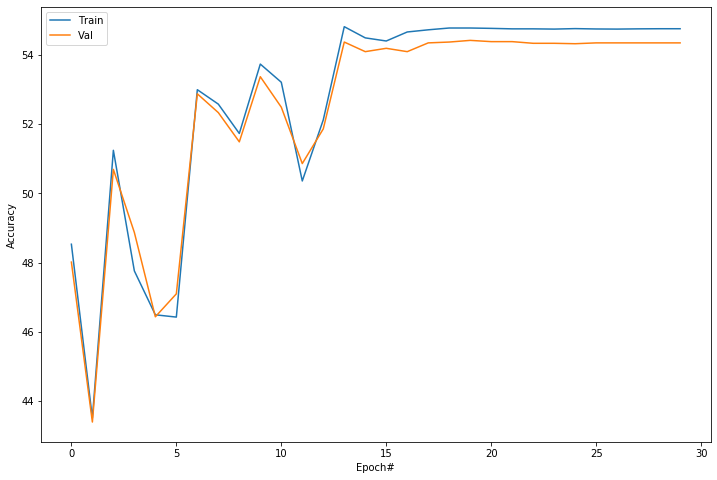

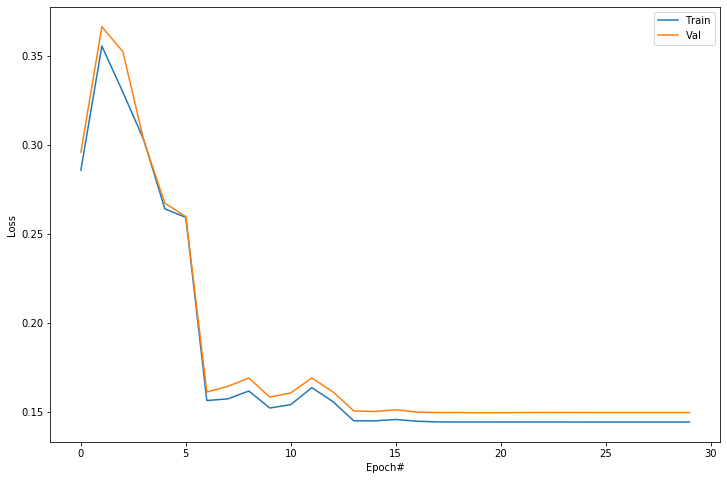

In [17]:
# TimeReversal initialization 
model_state_dict = torch.load('/beegfs/bva212/capstone/new_model/checkpoint_model.pth')['bestModelStateDict']
        
run_model(model_state_dict=model_state_dict, lr=0.01, num_epochs=30, model_suffix='time_reversal_chkpnt_15')

Epoch:1, Validation Accuracy:46.87, Training Acc: 46.78, Val Loss: 0.25706, Train Loss: 0.25620
Epoch:2, Validation Accuracy:44.28, Training Acc: 44.51, Val Loss: 0.27388, Train Loss: 0.27283
Epoch:3, Validation Accuracy:45.05, Training Acc: 45.50, Val Loss: 0.30267, Train Loss: 0.29181
Epoch     3: reducing learning rate of group 0 to 1.0000e-03.
Epoch:4, Validation Accuracy:44.28, Training Acc: 44.91, Val Loss: 0.33573, Train Loss: 0.32143
Epoch:5, Validation Accuracy:52.66, Training Acc: 52.90, Val Loss: 0.16385, Train Loss: 0.15928
Epoch:6, Validation Accuracy:53.72, Training Acc: 53.70, Val Loss: 0.15533, Train Loss: 0.15197
Epoch:7, Validation Accuracy:52.96, Training Acc: 53.07, Val Loss: 0.15763, Train Loss: 0.15370
Epoch:8, Validation Accuracy:53.05, Training Acc: 53.17, Val Loss: 0.15707, Train Loss: 0.15368
Epoch     8: reducing learning rate of group 0 to 1.0000e-04.
Epoch:9, Validation Accuracy:52.37, Training Acc: 52.86, Val Loss: 0.16029, Train Loss: 0.15409
Epoch:10, Va

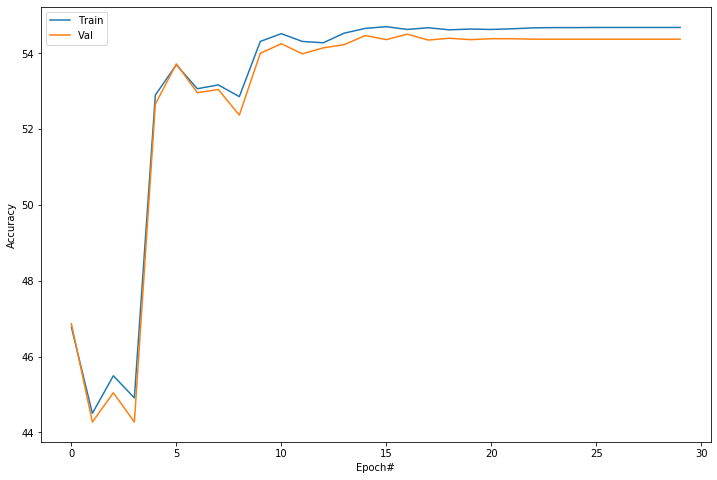

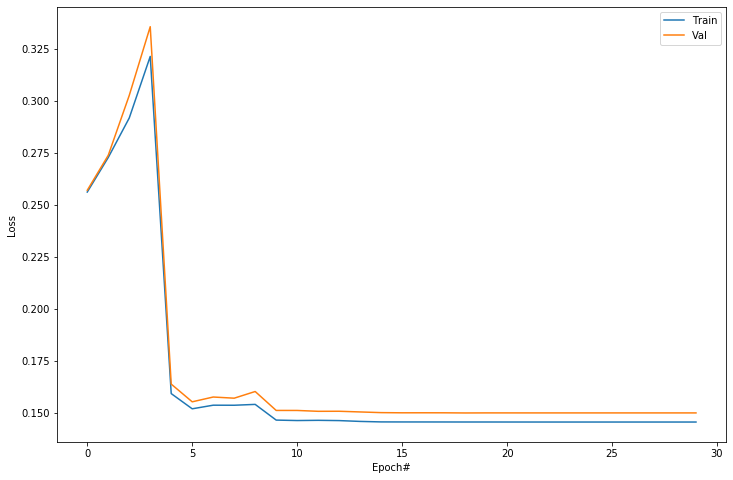

In [18]:
# TimeReversal initialization 
model_state_dict = torch.load('/beegfs/bva212/capstone/new_model/best_model.pth')['modelStateDict']
        
run_model(model_state_dict=model_state_dict, lr=0.01, num_epochs=30, model_suffix='time_reversal_best')

Epoch:1, Validation Accuracy:47.15, Training Acc: 46.58, Val Loss: 0.31067, Train Loss: 0.31273
Epoch:2, Validation Accuracy:45.08, Training Acc: 44.67, Val Loss: 0.31292, Train Loss: 0.31625
Epoch:3, Validation Accuracy:46.95, Training Acc: 46.80, Val Loss: 0.44654, Train Loss: 0.45067
Epoch:4, Validation Accuracy:50.11, Training Acc: 50.40, Val Loss: 0.29928, Train Loss: 0.28879
Epoch:5, Validation Accuracy:42.24, Training Acc: 43.24, Val Loss: 0.41180, Train Loss: 0.38855
Epoch:6, Validation Accuracy:41.55, Training Acc: 41.27, Val Loss: 0.39090, Train Loss: 0.37291
Epoch     6: reducing learning rate of group 0 to 1.0000e-03.
Epoch:7, Validation Accuracy:46.68, Training Acc: 47.09, Val Loss: 0.26970, Train Loss: 0.26166
Epoch:8, Validation Accuracy:54.24, Training Acc: 54.80, Val Loss: 0.17237, Train Loss: 0.16026
Epoch:9, Validation Accuracy:53.05, Training Acc: 53.28, Val Loss: 0.16572, Train Loss: 0.15545
Epoch:10, Validation Accuracy:52.61, Training Acc: 53.15, Val Loss: 0.1644

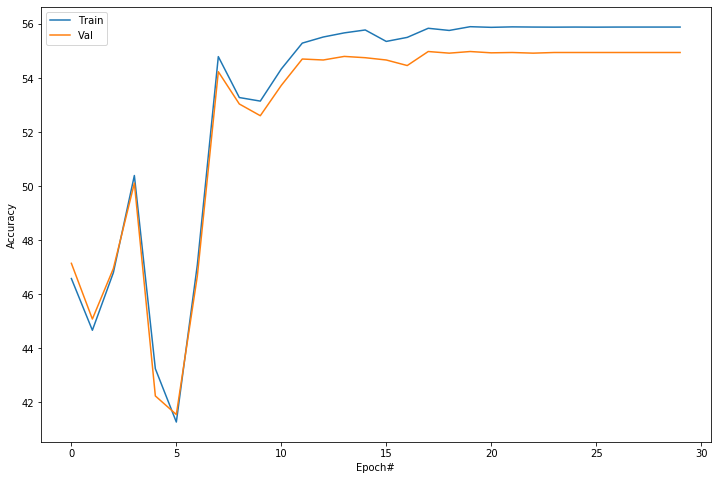

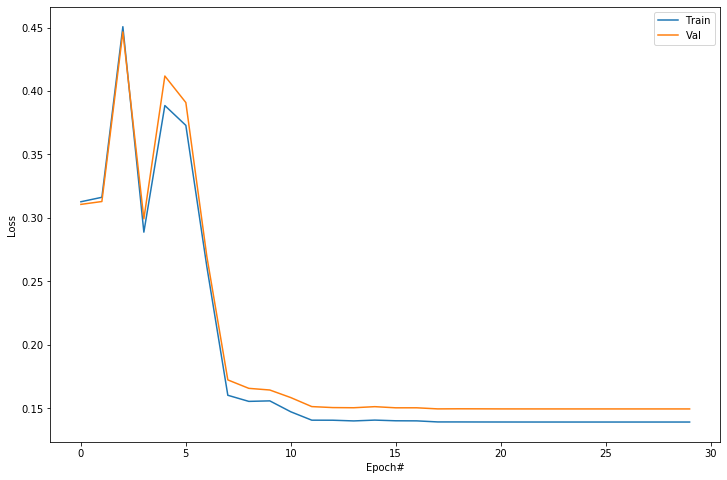

In [12]:
# Jigsaw initialization - 3/1 - w/linear
model_state_dict = torch.load('/beegfs/sc6957/capstone/models/20191116/snet2_jigsaw_large_best_model.pth')['modelStateDict']

run_model(model_state_dict=model_state_dict, lr=0.01, num_epochs=30, model_suffix='jigsaw_3_1_linear_best')

Epoch:1, Validation Accuracy:46.09, Training Acc: 45.26, Val Loss: 0.33549, Train Loss: 0.33470
Epoch:2, Validation Accuracy:42.85, Training Acc: 43.32, Val Loss: 0.31553, Train Loss: 0.30727
Epoch:3, Validation Accuracy:45.59, Training Acc: 45.31, Val Loss: 0.33449, Train Loss: 0.33866
Epoch     3: reducing learning rate of group 0 to 1.0000e-03.
Epoch:4, Validation Accuracy:43.68, Training Acc: 43.86, Val Loss: 0.29391, Train Loss: 0.29169
Epoch:5, Validation Accuracy:51.67, Training Acc: 51.18, Val Loss: 0.17296, Train Loss: 0.16843
Epoch:6, Validation Accuracy:47.26, Training Acc: 47.95, Val Loss: 0.18033, Train Loss: 0.17285
Epoch:7, Validation Accuracy:50.63, Training Acc: 50.55, Val Loss: 0.16698, Train Loss: 0.16224
Epoch     7: reducing learning rate of group 0 to 1.0000e-04.
Epoch:8, Validation Accuracy:50.09, Training Acc: 50.32, Val Loss: 0.16764, Train Loss: 0.16361
Epoch:9, Validation Accuracy:52.72, Training Acc: 52.91, Val Loss: 0.15557, Train Loss: 0.15117
Epoch:10, Va

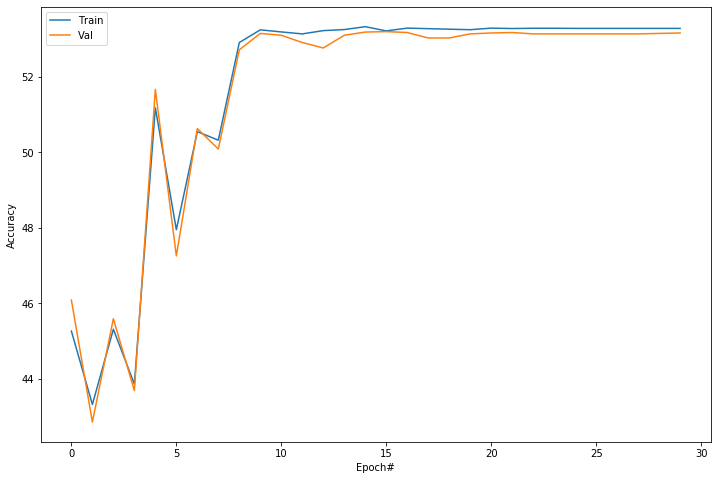

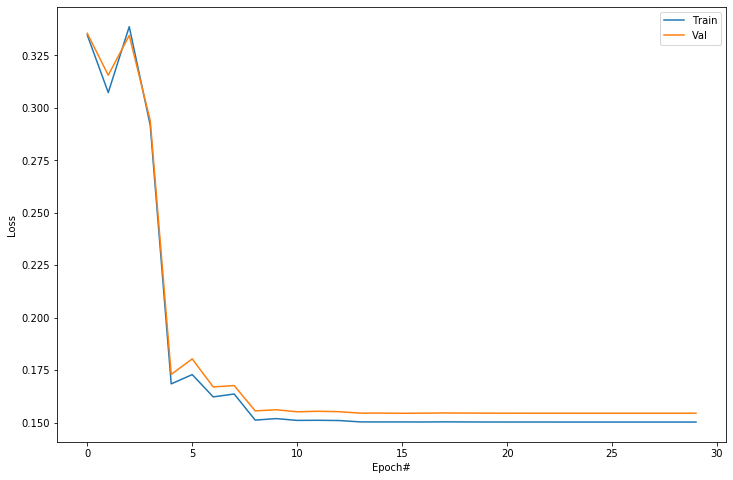

In [13]:
# Jigsaw initialization - 3/1
model_state_dict = torch.load('/beegfs/sc6957/capstone/models/20191116/snet3_jigsaw_large_best_model.pth')['modelStateDict']

run_model(model_state_dict=model_state_dict, lr=0.01, num_epochs=30, model_suffix='jigsaw_3_1_best')

In [12]:
model_file_path = '../../model/*'
results = {}
for model_file in glob(model_file_path):
    model_dict = torch.load(model_file)
    model_state_dict = model_dict['model_state_dict']
    model = AudioConvNet(fc=Identity())
    model.fc = SimpleMLP_Model()
    model.load_state_dict(model_state_dict)
    model.to(device)
    results_key = os.path.basename(model_file)[len('downstream_frozen_'):]
    results[results_key] = {}
    val_acc = np.array(model_dict['val_acc_list'])
    max_val_acc = max(val_acc)
    results[results_key]['val'] = (max_val_acc,  model_dict['val_loss_list'][np.where(val_acc == max_val_acc)[0][0]])
    results[results_key]['test'] = test_model(Test_loader, model)
 

key_order_map = {1: 'random_init', 2: 'jigsaw_linear_chkpnt_5', 3: 'jigsaw_linear_best', 4: 'jigsaw_3_1_linear_best', 5: 'jigsaw_3_1_best', \
                             6: 'time_reversal_chkpnt_15', 7: 'time_reversal_best'}
model_test_results = OrderedDict((value, results[value]) for key, value in sorted(key_order_map.items()))
model_test_results

OrderedDict([('random_init',
              {'val': (53.492580528411146, 0.18994841850548982),
               'test': (53.71782650142993, 0.19442906995117665)}),
             ('jigsaw_linear_chkpnt_5',
              {'val': (54.95234648329111, 0.1479104300737381),
               'test': (54.814108674928505, 0.15058614092320205)}),
             ('jigsaw_linear_best',
              {'val': (52.06900711786705, 0.16081451570242644),
               'test': (52.144899904671114, 0.16412473651766776)}),
             ('jigsaw_3_1_linear_best',
              {'val': (54.98853902762698, 0.14953402867540716),
               'test': (55.26692087702574, 0.1517835780531168)}),
             ('jigsaw_3_1_best',
              {'val': (53.20304017372421, 0.1544240789078176),
               'test': (52.97902764537655, 0.1584272965043783)}),
             ('time_reversal_chkpnt_15',
              {'val': (54.4215224996984, 0.14972737872228026),
               'test': (55.0047664442326, 0.15254591043293475)})

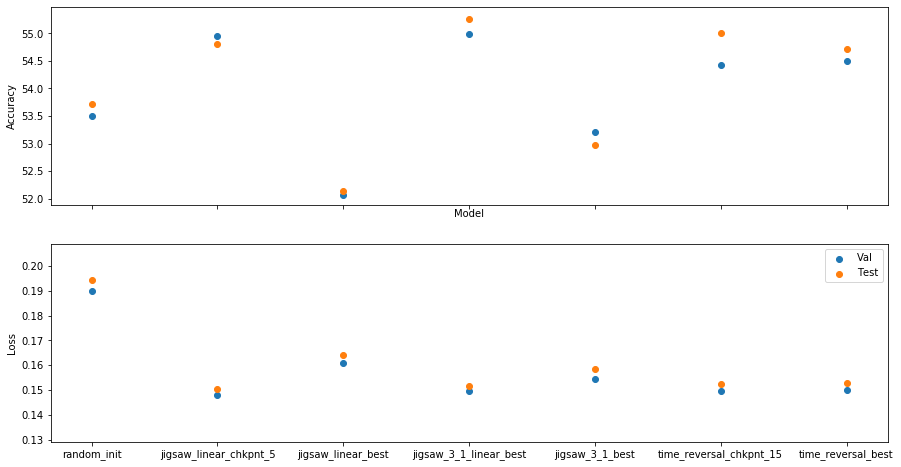

In [14]:
x = range(len(model_test_results))
key_list = list(model_test_results.keys())
values = np.array(list(model_test_results.values()))

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 8), sharex=True)

ax[0].scatter(x, [value['val'][0] for value in values], label='Val')
ax[0].scatter(x, [value['test'][0] for value in values], label='Test')
ax[0].set_ylabel('Accuracy')
ax[1].scatter(x, [value['val'][1] for value in values], label='Val')
ax[1].scatter(x, [value['test'][1] for value in values], label='Test')
ax[1].set_ylabel('Loss')

ax[0].set_xticks(x)    
ax[0].set_xticklabels(key_list, rotation=30)
ax[0].set_xlabel('Model')
# ax[0].legend(loc='best')
ax[1].legend(loc='best')

plt.show()

In [ ]:
sizes = [10, 50, 250, 500, 1000]
model_path_list = [('','random_init'),
                              ('/beegfs/sc6957/capstone/models/20191105/snet2_jigsaw_large_checkpoint_model_5.pth', 'jigsaw_10_3_linear_chkpnt_5'),
                              ('/beegfs/sc6957/capstone/models/20191106/snet2_jigsaw_large_best_model.pth', 'jigsaw_10_3_linear_best'),
                              ('/beegfs/bva212/capstone/new_model/checkpoint_model.pth', 'time_reversal_chkpnt_15'),
                              ('/beegfs/bva212/capstone/new_model/best_model.pth', 'time_reversal_best'),
                              ('/beegfs/sc6957/capstone/models/20191116/snet2_jigsaw_large_best_model.pth', 'jigsaw_3_1_linear_best'),
                              ('/beegfs/sc6957/capstone/models/20191116/snet3_jigsaw_large_best_model.pth', 'jigsaw_3_1_best')
                              ]

model_data = pickle.load(open('List_indices_data_size_exp.pkl', 'rb'))

r2 = re.compile('\w*chkpnt\w*')

model_state_dict = None
results_dict = {}

for model_path, model_suffix in model_path_list:
    
    print(model_suffix)
    if model_suffix != 'random_init':
        if r2.match(model_suffix) is None:
            model_state_dict = torch.load(model_path)['modelStateDict']
        else:
            model_state_dict = torch.load(model_path)['bestModelStateDict']
    
    for i in tqdm(range(len(sizes))):
        idx_train = model_data[i]
        Y_mask_train = Y_mask[idx_train]
        label_train = Y_true[idx_train]
        weights_train = np.sum(Y_mask_train, axis= 1)/20
        new_weights_train = weights_train.reshape(-1,1)*Y_mask_train
        Train_dataset = CQTLoader(root_dir, sample_key[idx_train], new_weights_train, label_train)
        Train_loader = torch.utils.data.DataLoader(dataset = Train_dataset, 
                                                                          batch_size = BATCH_SIZE,
                                                                          shuffle = True,
                                                                      collate_fn = my_collate)

        # Prepare/load model
        model = AudioConvNet(fc=Identity())

        if model_state_dict is not None: 
            for key in list(model_state_dict.keys()):
                cs = r1.search(key)
                if cs is None:
                    del model_state_dict[key]
                else:
                    model_state_dict[key[cs.start():]] = model_state_dict[key]
                    del model_state_dict[key]
#             print(model, model.state_dict().keys())
            model.load_state_dict(model_state_dict)

        for param in model.parameters():
                param.requires_grad = False

        model.fc = SimpleMLP_Model()
    #     print(model, model.state_dict())
        model.to(device)

        # Train
        optimizer = torch.optim.Adam([param for param in model.parameters() if param.requires_grad == True], lr=0.01, weight_decay = 0.01)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True, \
                                                               threshold=0.03, threshold_mode='abs', cooldown=0, min_lr=0, eps=1e-08)
        train_acc_list, train_loss_list, val_acc_list, val_loss_list, best_model_state_dict = train_model(Train_loader, Val_loader, \
                                                                                                          model, optimizer, scheduler, num_epochs=30)
    
    
        results_dict[sizes[i]] = {
            'train_acc_list': train_acc_list,
            'train_loss_list': train_loss_list,
            'val_acc_list': val_acc_list,
            'val_loss_list': val_loss_list,
            'model_state_dict': best_model_state_dict
        }
    
    file_path = '/home/jk6373/self_supervised_machine_listening/model/'
    file_name = 'downstream_frozen_' + model_suffix
    results_dict[1500] = torch.load(file_path+file_name)
    
    pickle.dump(results_dict, open(model_suffix+'_trng_data_size_results.pkl'.format(sizes[i]),'wb'))

  0%|          | 0/5 [00:00<?, ?it/s]

random_init
Epoch     9: reducing learning rate of group 0 to 1.0000e-03.
Epoch    13: reducing learning rate of group 0 to 1.0000e-04.
Epoch    19: reducing learning rate of group 0 to 1.0000e-05.
Epoch    22: reducing learning rate of group 0 to 1.0000e-06.
Epoch    25: reducing learning rate of group 0 to 1.0000e-07.
Epoch    28: reducing learning rate of group 0 to 1.0000e-08.


 20%|██        | 1/5 [04:15<17:02, 255.56s/it]

Epoch     5: reducing learning rate of group 0 to 1.0000e-03.
Epoch    10: reducing learning rate of group 0 to 1.0000e-04.
Epoch    14: reducing learning rate of group 0 to 1.0000e-05.
Epoch    17: reducing learning rate of group 0 to 1.0000e-06.
Epoch    20: reducing learning rate of group 0 to 1.0000e-07.
Epoch    23: reducing learning rate of group 0 to 1.0000e-08.


 40%|████      | 2/5 [09:55<14:02, 280.79s/it]

Epoch     4: reducing learning rate of group 0 to 1.0000e-03.
Epoch    12: reducing learning rate of group 0 to 1.0000e-04.
Epoch    23: reducing learning rate of group 0 to 1.0000e-05.
Epoch    26: reducing learning rate of group 0 to 1.0000e-06.


 60%|██████    | 3/5 [22:05<13:51, 415.58s/it]

Epoch    29: reducing learning rate of group 0 to 1.0000e-07.
Epoch     3: reducing learning rate of group 0 to 1.0000e-03.
Epoch     7: reducing learning rate of group 0 to 1.0000e-04.
Epoch    13: reducing learning rate of group 0 to 1.0000e-05.
Epoch    21: reducing learning rate of group 0 to 1.0000e-06.
Epoch    24: reducing learning rate of group 0 to 1.0000e-07.
Epoch    27: reducing learning rate of group 0 to 1.0000e-08.


 80%|████████  | 4/5 [42:41<11:01, 661.79s/it]

Epoch     7: reducing learning rate of group 0 to 1.0000e-03.
Epoch    11: reducing learning rate of group 0 to 1.0000e-04.


In [15]:
results = pickle.load(open('random_init_trng_data_size_results.pkl', 'rb'))

In [17]:
model_file_path = '../../model/*'
results = {}
for model_file in glob(model_file_path):
    model_dict = torch.load(model_file)
    model_state_dict = model_dict['model_state_dict']
    model = AudioConvNet(fc=Identity())
    model.fc = SimpleMLP_Model()
    model.load_state_dict(model_state_dict)
    model.to(device)
    results_key = os.path.basename(model_file)[len('downstream_frozen_'):]
    results[results_key] = {}
    val_acc = np.array(model_dict['val_acc_list'])
    max_val_acc = max(val_acc)
    results[results_key]['val'] = (max_val_acc,  model_dict['val_loss_list'][np.where(val_acc == max_val_acc)[0][0]])
    results[results_key]['test'] = test_model(Test_loader, model)
 

key_order_map = {1: 'random_init', 2: 'jigsaw_linear_chkpnt_5', 3: 'jigsaw_linear_best', 4: 'jigsaw_3_1_linear_best', 5: 'jigsaw_3_1_best', \
                             6: 'time_reversal_chkpnt_15', 7: 'time_reversal_best'}
model_test_results = OrderedDict((value, results[value]) for key, value in sorted(key_order_map.items()))
model_test_results

dict

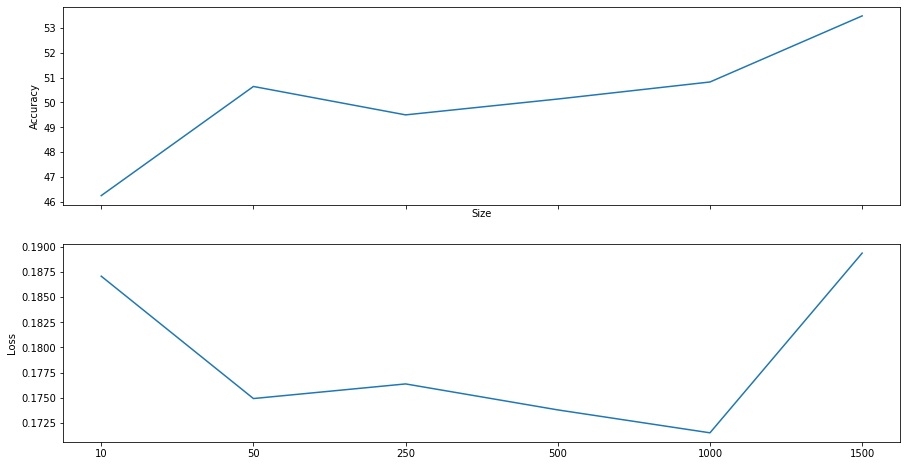

In [19]:
x = range(len(results))
key_list = list(results.keys())
values = np.array(list(results.values()))

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 8), sharex=True)

ax[0].plot([max(value['val_acc_list']) for value in values], label='Random')
# ax[0].scatter(x, [value['test'][0] for value in values], label='Test')
ax[0].set_ylabel('Accuracy')
ax[1].plot([min(value['val_loss_list']) for value in values], label='Random')
# ax[1].scatter(x, [value['test'][1] for value in values], label='Test')
ax[1].set_ylabel('Loss')

ax[0].set_xticks(x)    
ax[0].set_xticklabels(key_list, rotation=30)
ax[0].set_xlabel('Size')
# ax[0].legend(loc='best')
# ax[1].legend(loc='best')

plt.show()